<a href="https://colab.research.google.com/github/youngpaper1115/Git_Tutorial/blob/main/Lending_Club_Project_ver1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#google drive mount 및 파일 경로 지정

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# 필요 라이브러리 import 및 현재 작업공간 확인

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
%matplotlib inline

os.getcwd()

'/content'

In [15]:
# 데이터 불러오기

lc_df = pd.read_stata('/content/drive/MyDrive/Python_SNU/Lending_Club/lendingclub.dta')

In [16]:
# emp_length 결과 불러오기

result_list = []

f = open('/content/drive/MyDrive/Python_SNU/Lending_Club/emp_length.txt', 'r')
numb = f.read()
f.close()

result_list = numb.split(",")
del result_list[-1]

In [17]:
# raw data에 emp_length 컬럼 추가

lc_df['emp_length'] = result_list

# **<< Column에 대한 생각 정리>>**

1. **loan_amnt**, funded_amnt, funded amnt_inv : 대부분 같은 값으로 loan_amnt 컬럼으로 통일

2. **int_rate** : 이자율.. 유지

3. installment : 대출자의 월 지급액. 총량 / 기간으로 계산되므로 del

4. **annual_inc** : 대출자의 자진신고 연소득.. 유지

5. **dti** : ??? 이해 안감...ㅜㅜ 설명좀.. --> 대출 실질 상환 가능성?? 넣는 것으로. 높으면 위험한 값

6. **delinq_2yrs** : 근 2년간 대출자의 연체 발생일수 30일 이상.. 유지

7. fico_range_low, fico_range_high : 대출자의 FICO 하한&상한 범위? FICO란? 포함시킬 경우, 둘의 평균값 넣는 것이 나을 듯

8. **inq_last_6mths** : 6개월간 조회수.

9. **open_acc** : 신용파일이 열린 수. / 카드 여러개..

10. **pub_rec** : 나쁜 공공기록의 수..? 신용등급이 낮은 경우일 것 같으므로 우선 포함

11. revol_bal, **revol_util** : 리볼빙(광역할부..라 합니다) 금액 및 소비율. 소비율이 낮을수록 연체 비율이 줄지 않을까..? 우선 소비율만 포함

12. **total_acc** : 대출자 신용 파일의 총 신용 한도 수.. 데이터 확인 (open_acc와 비교... total은 현재 전체 계좌 보유 수, open이 계좌 개설 수)

13. out_prncp, out_prncp_inv : 잔존 원금들.. 연체면 0이 아닐 것.. 우선 제외 -> 제외 이유는 말할 것. 체크 필요

14. total_pymnt, total_pymnt_inv : 총 지급액.. 원금*이자율 결과물일테니 제외

15. total_rec_prncp, total_rec_int, total_rec_late_fee : 수령한 원금, 이자, 연체료. 원금 및 이자는 불필요. 연체료는 depvar이 0인 경우에 발생하기도 하고, 1인 경우에 발생하지 않은 경우도 있어서.. 제외. late_fee의 경우는 위의 delinq_2yrs 컬럼과 상관성 확인 필요

16. recoveries, **collection_recovery_fee** : 총회복 연기, 추심료 우송..? 개념은 이해 안감. 단, 종속변수가 1인 경우에만 발생(물론 0인 경우도 존재). recoveries를 5.555..로 나눈 값이 collection_recovery_fee 인듯. 뒤 값만 사용 -> 개인 회생 관련 목록이 있으면 제외

17. last_pymnt_amnt : 마지막 받은 총 지급액.. 제외

18. last_fico_range_high, last_fico_range_low : FICO가 대체 뭐람.. 포함시킬 경우 둘의 평균값을 넣자

19. **collections_12_mths_ex_med** : 의료수거 제외 12개월간 수거 횟수..? -> 의료비로 인한 상환 불가 경우 제외하고 채권 회수 건수. Classification에 쓸 수 있을 듯

20. **acc_now_delinq** : 현재 연체 중인 계정 수.. 우선 포함 (loan_amnt 대비율 살펴보기)

21. tot_coll_amt, **tot_cur_bal** : 총 추심 금액 및 모든 계정의 경상 잔액. (cur는 모든 금융권의 남은 대출 잔액. 타금융권의 계좌도 확인 필요)

22. **chargeoff_within_12_mths** : 손실 처리 횟수.

23. **delinq_amnt** : 현재 연체 중인 계좌의 연체 금액. 위에 연체 계정 수가 있으니 우선 제외 -> 금액은 계좌 수와 다른 것이니 추가

24. **pub_rec_bankruptcies** : 공공 파산 기록 건수. -> 상관계수 보고 결정..

25. **tax_liens** : 세금 안내서 압류잡힌거..ㅜ -> 세금이 우선순위이기에 이것이 있으면 상환 못할 확률 높음

26. ***emp_length*** 1 ~ 12 : 고용 기간. 설명에는 0~10까지의 값만을 가진다고 하였지만 column은 12까지 존재. 이 column은 emp_length 하나의 column으로 통일한 후, 각 가능 고용기간을 int로 넣겠음

27. home_ownership 1~6 : 주택 보유 현황.. 이건 종속 변수와의 관계를 봐야할 것 같다. -> 관계 확인 필요

28. verification_status 1~3 : 소득의 확인 여부... 대출자의 신뢰도를 판단하는 기준이 될 수 있을지도? -> 관계 확인 필요

29. purpose 1~14 : 제외

30. addr_state 1~51 : 대출자가 살고 있는 주. 우선 제외

31. initial_list_status : 대출 초기 목록 상태(W : 가조회, F : 본조회) -> 조교님께 물어보기 : 한명한테 빌리냐(W) or 여럿한테 빌리냐(F)

32. elapsed_t : 뭐야 넌 --> 작년엔 사용하지 않은 변수

33. ***issue_d*** 1~118 : 융자금 지원 달.. 우선 int화 
시키기 --> 융자금을 받은 후 지난 일수.. issue_d1의 경우는 579+1일  -> 조교님/께 문의

34. **debt_settlement_flag** : 채무 조정 회사와 협력 여부. 0인 경우 종속변수가 1되는 경우가 몇몇 있는 듯

35. ***term*** : 지불 수. 월 단위로 36 or 60  --> 조교님께 문의

36. **depvar : 종속변수.**

37. ***mths_since_last_delinq*** 1~11 : 대출자의 마지막 연체 이후 개월 수. 이것도 우선 int화 -> 조교님게 여쭤보기. Delinquent_1인 경우가 바로 저번달 연체 경우가 맞는지?

38. ***mths_since_last_major_derog*** 1~11: 해석이 잘.. 우선 int화 -> 조교님께 여쭤보기. 90일 또는 그 이상 연체 후 지난 달이 맞는가? 또한 연체가 없었을 경우 derog1으로 처리???

39. ***mths_since_last_record*** 1~11 : 마지막 공공 기록 이후 개월 수? int화

40. ***mths_since_rcnt_il*** 1~11 : 최근 할부 계좌 open 후 월 int화. -> 조교님께 문의..

41. ***mths_since_recent_bc*** 1 ~ 11 : 은행카드 개설 후 지난 월 수. int화

42. ***mths_since_recent_bc_dlq*** 1 ~ 11 : 은행카드 연체 이후 월 수. int화

43. ***mths_since_recent_inq*** 1 ~ 10 : 최근 문의 이후 월 수. int화

44. ***mths_since_recent_revol_delinq*** 1 ~ 11 : 최근 리볼빙 불량 이후 지난 월 수. int화


==> 마지막 변수들 month가 정말 달을 말하는 것인가 or구간을 말하는 것인가? 0이나 11인 경우는 이하or이상의 값까지 볼 것인가

## **<컬럼 분석 시작>**

1. open_acc vs total_acc

In [18]:
# open_acc, total_acc, 종속변수만 불러온 임시 데이터프레임 생성
temp_df = lc_df[['open_acc','total_acc','depvar']]

# total_acc 대비 open_acc 값의 비율을 계산한 열 추가(컬럼명 : ratio)
temp_df['ratio'] = temp_df['open_acc'] / temp_df['total_acc']

# ratio 값이 1이 넘는 경우가 있는가? (= total_acc 값보다 open_acc 값이 높은 경우가 있는가?)
print(temp_df[temp_df['ratio'] > 1 ])

Empty DataFrame
Columns: [open_acc, total_acc, depvar, ratio]
Index: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
# 종속변수 depvar에 따른 비율의 평균값 보기

good_temp = temp_df[temp_df['depvar'] == 0] # depvar = 0의 경우, 상환완료
bad_temp = temp_df[temp_df['depvar'] == 1] # depvar = 1의 경우, 상환x

print(good_temp.mean(axis=0))
print(bad_temp.mean(axis=0))

open_acc     11.535759
total_acc    24.763559
depvar        0.000000
ratio         0.504338
dtype: float64
open_acc     11.806881
total_acc    24.507205
depvar        1.000000
ratio         0.524203
dtype: float64


In [22]:
# 두 독립표본의 평균 차이를 검정하는 t-검정 진행
from scipy import stats

a = stats.ttest_ind(good_temp['open_acc'], bad_temp['open_acc'], equal_var=False)  # open_acc 비교, 등분산 가정x
b = stats.ttest_ind(good_temp['total_acc'], bad_temp['total_acc'], equal_var=False) # total_acc 비교, 등분산 가정x
c = stats.ttest_ind(good_temp['ratio'], bad_temp['ratio'], equal_var=False) # ratio 비교, 등분산 가정x

print(a)
print(b)
print(c)

Ttest_indResult(statistic=-18.976383826862325, pvalue=3.050723544241765e-80)
Ttest_indResult(statistic=8.248292484919812, pvalue=1.6144734283596048e-16)
Ttest_indResult(statistic=-42.24277962954272, pvalue=0.0)


2. delinq_2yrs, total_rec_late_fee

In [23]:
from scipy import stats
# delinq_2yrs, total_rec_late_fee, 종속변수만 불러온 임시 데이터프레임 생성
temp_df = lc_df[['loan_amnt','delinq_2yrs','total_rec_late_fee','depvar','delinq_amnt']]

good_temp = temp_df[temp_df['depvar'] == 0]  # depvar = 0의 경우, 상환완료
bad_temp = temp_df[temp_df['depvar'] == 1] # depvar = 1의 경우, 상환x

In [25]:
# delinq_2yrs, total_rec_late_fee, 두 변수간의 상관관계 확인
a = stats.pearsonr(good_temp['delinq_2yrs'], good_temp['total_rec_late_fee'])
b = stats.pearsonr(bad_temp['delinq_2yrs'], bad_temp['total_rec_late_fee'])

print(a) # 상환완료의 경우, 상관관계가 높지 않음
print(b) # 상환x의 경우 어느정도 양의 상관관계를 가짐. 즉, 최근 2년간 30일 이상 연체된 경우가 많을수록, 수령한 연체료는 높아짐

(0.030070104137715423, 3.08224967094869e-182)
(0.059281020340420695, 2.1514720359408676e-137)


In [26]:
# loan_amnt, total_rec_late_fee 두 변수간의 상관관계 확인
a = stats.pearsonr(good_temp['loan_amnt'], good_temp['total_rec_late_fee'])
b = stats.pearsonr(bad_temp['loan_amnt'], bad_temp['total_rec_late_fee'])

print(a)
print(b)

(0.06417801938807616, 0.0)
(0.1565676683263683, 0.0)


In [27]:
# delinq_amnt, total_rec_late_fee 두 변수간의 상관관계 확인
a = stats.pearsonr(good_temp['delinq_amnt'], good_temp['total_rec_late_fee'])
b = stats.pearsonr(bad_temp['delinq_amnt'], bad_temp['total_rec_late_fee'])

print(a)
print(b)

(0.0026352968052447356, 0.011658404193280517)
(0.001084996847009269, 0.6482153039211674)


3. pub_rec_bankruptcies

In [30]:
# pub_rec_bankruptcies, 종속변수만 불러온 임시 데이터프레임 생성
temp_df = lc_df[['pub_rec_bankruptcies','depvar']]

# pub_rec_bankruptcies와 종속변수의 상관관계 분석 진행
stats.pearsonr(temp_df['pub_rec_bankruptcies'], temp_df['depvar']) # 매우 약한 양의 상관관계, 유의하다고 보긴 힘들듯. 즉, 공공파산 기록 건수가 높다고 해서 depvar이 높진 않은듯

(0.025926852615437927, 7.675955367963358e-162)

4. home_ownership

In [31]:
# home_ownership1~6, 종속변수만 불러온 임시 데이터프레임 생성
temp_list = list(filter(lambda x: 'home_ownership' in x, lc_df.columns.tolist())) # 컬럼명 중 'home_ownership'이란 단어가 들어가는 컬럼명만 추출 후 리스트로 변환
temp_list.append('depvar') # 변환 리스트에 종속변수 depvar 값 추가
temp_df = lc_df[temp_list]

good_temp = temp_df[temp_df['depvar'] == 0] # depvar = 0의 경우, 상환완료
bad_temp = temp_df[temp_df['depvar'] == 1] # depvar = 1의 경우, 상환x

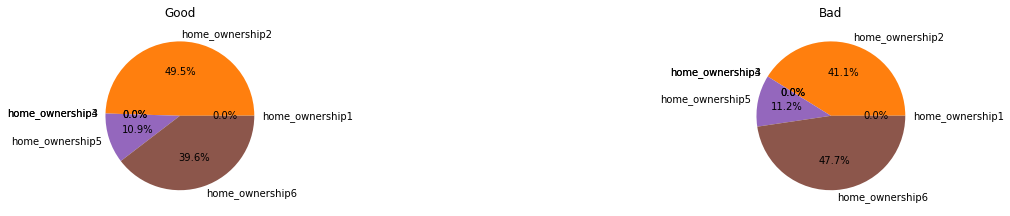

In [48]:
fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
good_sum = good_temp.sum(axis=0)[:-1]
plt.pie(good_sum.values, labels=good_sum.index, autopct='%.1f%%')
plt.title('Good')

plt.subplot(1,2,2)
bad_sum = bad_temp.sum(axis=0)[:-1]
plt.pie(bad_sum.values, labels=bad_sum.index, autopct='%.1f%%')
plt.title('Bad')

plt.subplots_adjust(wspace = 2.5)
plt.show()

In [49]:
# 비율 비교
# good에 영향을 주는 변수는 일단 고려x, 데이터수도 어느정도 있으면서 가장 큰 영향을 주는 것으로 보이는 home_ownership6 변수만 우선 사용해보자

print('전체 Default 비율은: ' + str(len(bad_temp) / len(temp_df)))
print('각 home_ownership 별 데이터 수')
print(good_sum + bad_sum)
print('각 home_ownership 별 Default 비율')
print(bad_sum / (good_sum + bad_sum))

전체 Default 비율은: 0.16179058100371574
각 home_ownership 별 데이터 수
home_ownership1       382.0
home_ownership2    525834.0
home_ownership3        42.0
home_ownership4        45.0
home_ownership5    119577.0
home_ownership6    447039.0
dtype: float64
각 home_ownership 별 Default 비율
home_ownership1    0.133508
home_ownership2    0.138234
home_ownership3    0.166667
home_ownership4    0.177778
home_ownership5    0.165492
home_ownership6    0.188532
dtype: float64


5. verification_status

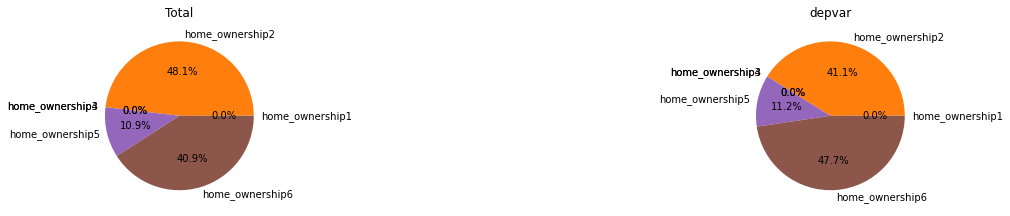

In [51]:
# home_ownership 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'home_ownership' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

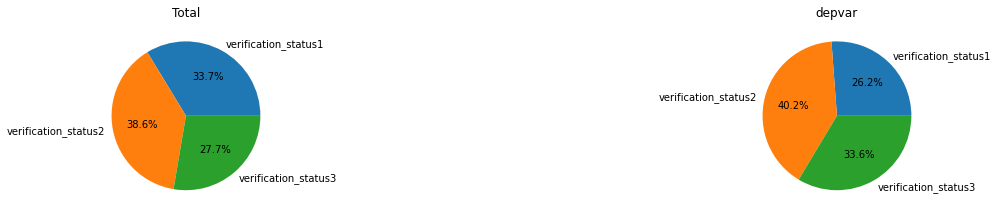

In [52]:
# verification_status 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'verification_status' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

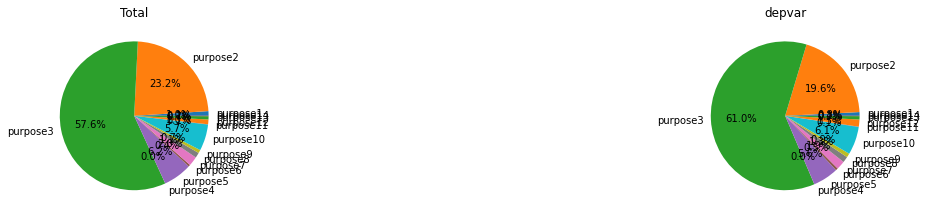

In [53]:
# purpose 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'purpose' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

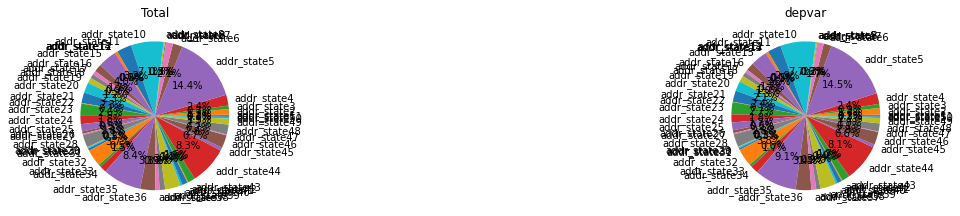

In [54]:
# addr_state 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'addr_state' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

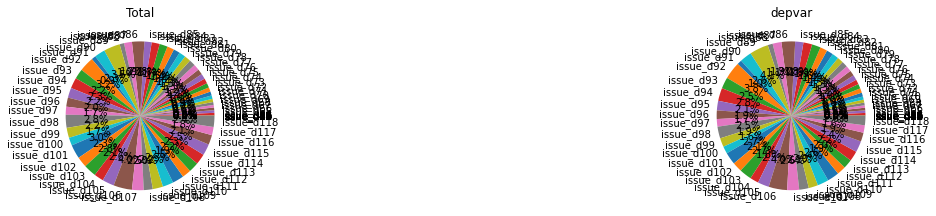

In [55]:
# issue_d 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'issue_d' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

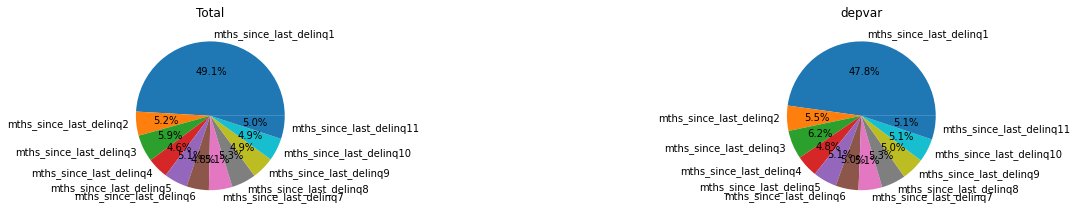

In [56]:
# mths_since_last_delinq 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_last_delinq' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

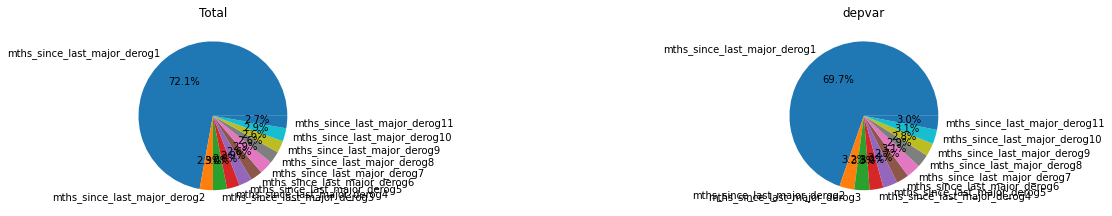

In [58]:
# mths_since_last_major_derog 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_last_major_derog' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

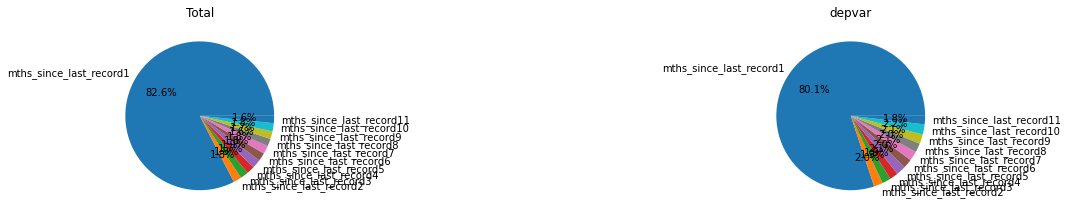

In [59]:
# mths_since_last_record 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_last_record' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

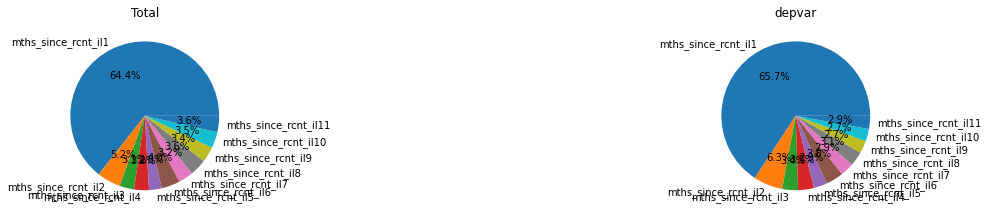

In [60]:
# mths_since_rcnt 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_rcnt' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

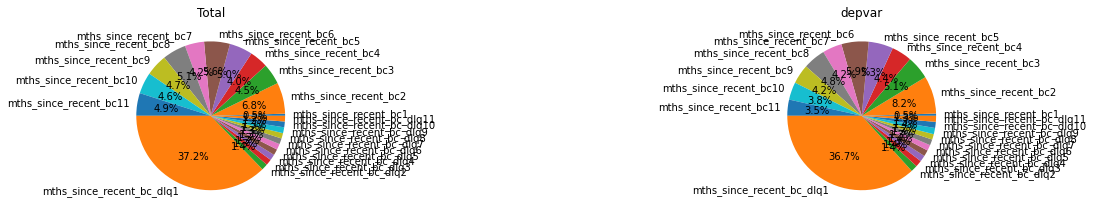

In [61]:
# mths_since_recent_bc 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_recent_bc' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

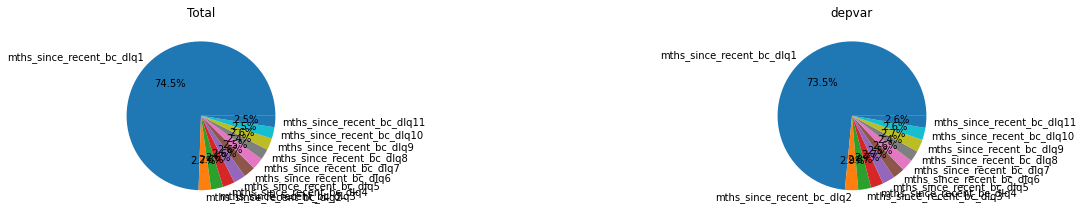

In [62]:
# mths_since_recent_bc_dlq 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_recent_bc_dlq' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

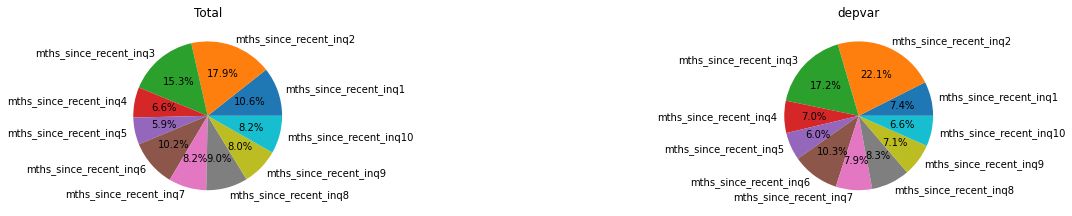

In [63]:
# mths_since_recent_inq 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_recent_inq' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()

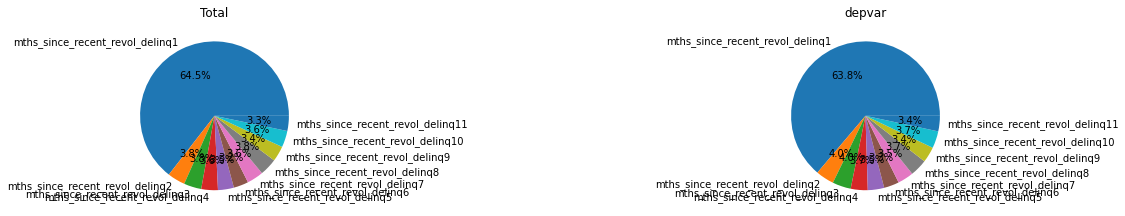

In [64]:
# mths_since_recent_revol_delinq 컬럼과 종속변수와의 관계 살펴보기

temp_list = list(filter(lambda x: 'mths_since_recent_revol_delinq' in x, lc_df.columns.tolist()))
temp_list.append('depvar')
temp_df = lc_df[temp_list]

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
temp_sum = temp_df.sum(axis=0)[:-1]
plt.pie(temp_sum.values, labels=temp_sum.index, autopct='%.1f%%')
plt.title('Total')

plt.subplot(1,2,2)
temp_df2 = temp_df[temp_df['depvar']==1]
temp_sum2 = temp_df2.sum(axis=0)[:-1]
plt.pie(temp_sum2.values, labels=temp_sum2.index, autopct='%.1f%%')
plt.title('depvar')

plt.subplots_adjust(wspace=2.5)
plt.show()